In [24]:
%load_ext autoreload
%autoreload 2
import sys
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
import matplotlib.pyplot as plt

LOG.propagate = False
LOG.debug("debug")
LOG.info("info")
LOG.warning("warning")
LOG.error("error")
LOG.critical("critical")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-02 11:22:26,675 | INFO     |: info
2024-05-02 11:22:26,676 | WARNING  |: warning
2024-05-02 11:22:26,676 | ERROR    |: error
2024-05-02 11:22:26,677 | CRITICAL |: critical


In [18]:
ble = get_ble_controller() # Get ArtemisBLEController object
ble.connect() # Connect to the Artemis Device

2024-04-29 01:27:35,580 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:89:c1:6d:24:4b
2024-04-29 01:27:40,171 | INFO     |: Connected to c0:89:c1:6d:24:4b


In [19]:
ble.send_command(CMD.ECHO, "HiHello")
output1 = ble.receive_string(ble.uuid['RX_STRING'])
print(output1)

Robot says: HiHello :)


In [20]:
raw_message=[]
#add more arrays if needed
num = []
timeToF = [] #in seconds
distanceF = [] 
distanceS = [] 
error = []
PIDoutput = []
timePID = []
def clear_data():
    # Clear all the sensor data arrays
    distanceF.clear()
    distanceS.clear()
    timeToF.clear()
    error.clear()
    PIDoutput.clear()
    timePID.clear()

def notification_handler(uuid, byte_array):
    global distanceF,distanceS,timeToF,error,PIDoutput,timePID
    raw_message.append(byte_array)
    message = ble.bytearray_to_string(byte_array)
    if message=='ToF data received.':
        print(message)
        isPID = True
    elif message=='PID data received.':
        print(message)
    else:
        readings = message.split('|')
        num.clear()
        for reading in readings:
            label, value = reading.split(':')
            num.append(float(value))
        if len(num)==3:
            if label=="Side Distance":
                timeToF.append(num[0]/1000)
                distanceF.append(num[1])
                distanceS.append(num[2])
            elif label=="PID output":
                timePID.append(num[0]/1000)
                error.append(num[1])
                PIDoutput.append(num[2])

In [21]:
ble.start_notify(ble.uuid['RX_STRING'], notification_handler)

In [22]:
clear_data()
ble.send_command(CMD.GET_DISTANCE, "1000|3200|4000")

ToF data received.


In [23]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [24]:
print(f"It takes: {round(timeToF[-1]-timeToF[0],3)}s to collect data.")
print(f"Sample rate is about {round(len(timeToF)/(timeToF[-1]-timeToF[0]),2)} samples/s.")

It takes: 3.853s to collect data.
Sample rate is about 10.12 samples/s.


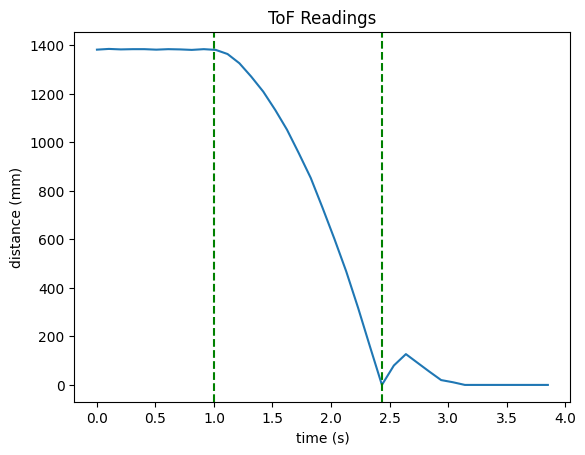

In [93]:
plt.plot(np.array(timeToF)-timeToF[0], np.array(distanceF))
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title('ToF Readings')
plt.axvline(x=1,ls='--',color='g')
plt.axvline(x=timeToF[24]-timeToF[0],ls='--',color='g');

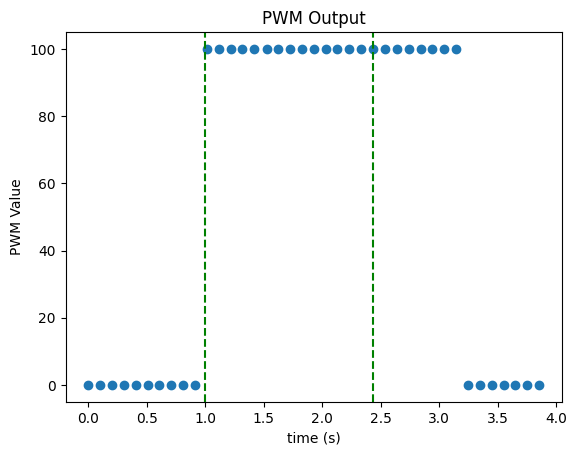

In [51]:
plt.scatter(np.array(timeToF)-timeToF[0], distanceS)
plt.xlabel('time (s)')
plt.ylabel('PWM Value')
plt.title('PWM Output')
plt.axvline(x=1,ls='--',color='g')
plt.axvline(x=timeToF[24]-timeToF[0],ls='--',color='g');

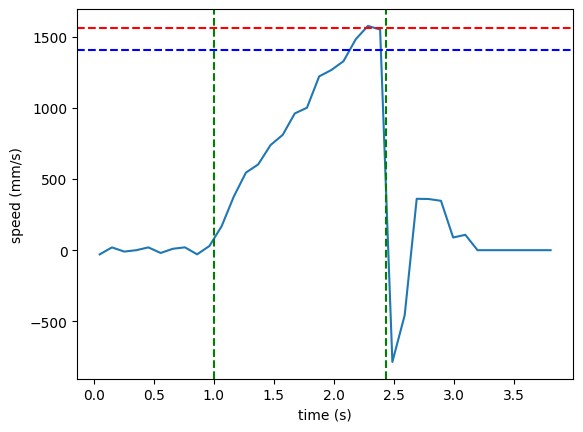

In [62]:
speed= np.diff(distanceF) / np.diff(timeToF)
time= (np.array(timeToF)[:-1] + np.array(timeToF)[1:]) / 2
plt.plot(time-timeToF[0], -speed)
plt.xlabel('time (s)')
plt.ylabel('speed (mm/s)')
plt.axvline(x=1,ls='--',color='g')
plt.axhline(y=1560,ls='--',color='r',label='Steady State Speed')
plt.axvline(x=timeToF[24]-timeToF[0],ls='--',color='g');

In [33]:
file_path = 'data.csv'
data = []
timeToF = []
distanceF = []
PID = []
with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        data.append(line.strip().split(','))
data = np.array(data)[1:,:]
for i in range(len(data)):
    timeToF.append(float(data[i,0]));
    distanceF.append(float(data[i,1]));
    
speed= np.diff(distanceF) / np.diff(timeToF)
time= (np.array(timeToF)[:-1] + np.array(timeToF)[1:]) / 2
spd = speed
t = time-timeToF[0]
print(f'speed of the moving car in mm/s are \n{spd}')

speed of the moving car in mm/s are 
[ -29.41176471   19.60784314   -9.80392157    0.           19.60784314
  -19.60784314    9.9009901    20.          -29.12621359   29.41176471
  168.31683168  376.23762376  544.55445545  601.94174757  737.86407767
  810.          960.         1000.         1220.         1264.70588235
 1326.73267327 1480.39215686 1574.25742574 1549.01960784 -784.31372549
 -456.31067961  360.82474227  359.22330097  346.53465347   89.10891089
  107.84313725    0.            0.            0.            0.
    0.            0.            0.        ]


In [34]:
SS_spd = 1560 #estimated steady state speed in mm/s at pwm of 100.
SS_spd90 = 0.9*SS_spd 
t_rising = (t[21]-t[20])/(spd[21] - spd[20])*(SS_spd90-spd[20])+t[20] - 1 #interpolation
print(f"The 90% steady speed is {SS_spd90}mm/s with 90% rising time of {round(t_rising,2)} seconds")

The 90% steady speed is 1404.0mm/s with 90% rising time of 1.13 seconds


In [70]:
SS_spd = 1560 #estimated steady state speed in mm/s at pwm of 100.
SS_spd90 = 0.9*SS_spd 
t_rising = (t[21]-t[20])/(spd[21] - spd[20])*(SS_spd90-spd[20])+t[20] - 1 #interpolation
print(f"The 90% steady speed is {SS_spd90}mm/s with 90% rising time of {round(t_rising,2)} seconds")
d = 1/SS_spd90*1000 # Assuming u = 1 Newton
m = -d*t_rising/np.log(0.1) 
print(f"d = {d}")
print(f"m = {m}")
A = np.array([[0,1], [0, -d/m]])
B = np.array([[0], [1/m]])
C = np.array([[1,0]])
dt = 1/10.12 #the sample rate is 10.12 samples/seconds
Ad = np.eye(2) + dt * A  
Bd = dt * B

d = 0.7122507122507122
m = 0.34970574775826285


In [72]:
A = np.array([[0,1], [0, -d/m]])
B = np.array([[0], [1/m]])
C = np.array([[1,0]])
dt = 1/10.12 #the sample rate is 10.12 samples/seconds
Ad = np.eye(2) + dt * A  
Bd = dt * B

In [73]:
file_path = 'PID3.csv'
data = []
time = []
distance = []
PID = []
with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        data.append(line.strip().split(','))
data = np.array(data)[1:,:]
for i in range(len(data)):
    time.append(float(data[i,0]));
    distance.append(float(data[i,1]));
    PID.append(float(data[i,2]));
time = np.array(time)-time[0]
distance = np.array(distance)
PID = np.array(PID)

In [74]:
file_path = 'ToF3.csv'
data = []
timeF = []
distanceF = []
with open(file_path, 'r') as file:
    lines = file.readlines()
    for line in lines:
        data.append(line.strip().split(','))
data = np.array(data)[1:,:]
for i in range(len(data)):
    timeF.append(float(data[i,0]));
    distanceF.append(float(data[i,1]));
timeF = np.array(timeF)-timeF[0]
distanceF = np.array(distanceF)

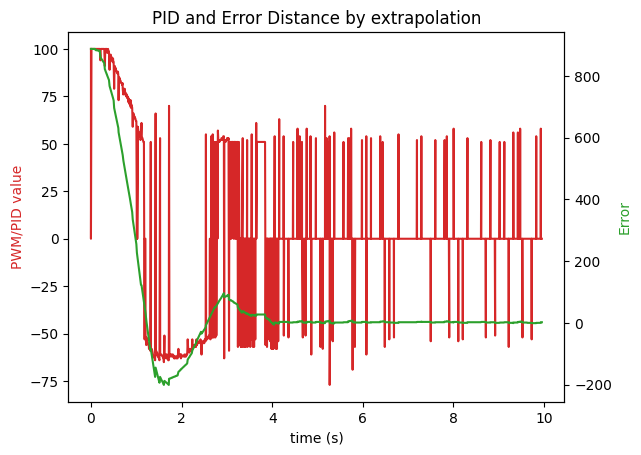

In [75]:
fig, ax1 = plt.subplots() 
color = 'tab:red'
ax1.set_xlabel('time (s)') 
ax1.set_ylabel('PWM/PID value', color = color) 
ax1.plot(time,PID, label = 'PID', color = color)
ax2 = ax1.twinx() 
color = 'tab:green'
ax2.set_ylabel('Error', color = color) 
ax2.plot(time,distance, label = 'error', color = color)
plt.title("PID and Error Distance by extrapolation")
plt.show();

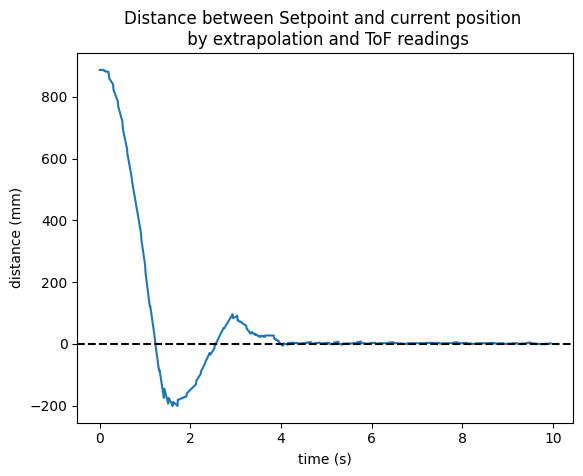

In [76]:
plt.plot(time, distance)
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title("Distance between Setpoint and current position \n by extrapolation and ToF readings")
plt.axhline(y=0,ls='--',color='k');

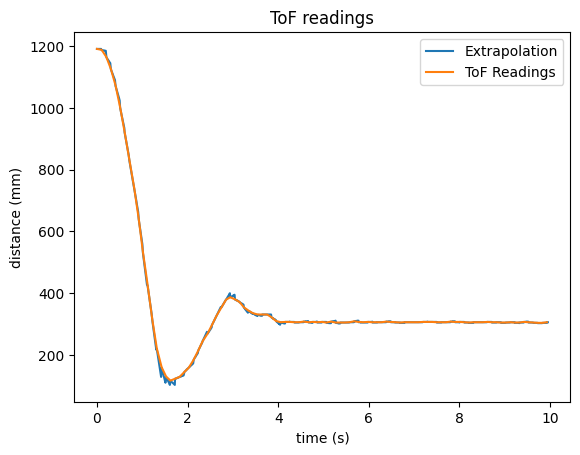

In [77]:

plt.plot(time, distance+304, label = 'Extrapolation')
plt.plot(timeF, distanceF, label = 'ToF Readings')
plt.xlabel('time (s)')
plt.ylabel('distance (mm)')
plt.title("ToF readings")
plt.legend();

In [78]:
def kf(mu,sigma,u,y):
    mu_p = Ad.dot(mu) + Bd.dot(u)   
    sigma_p = Ad.dot(sigma.dot(Ad.transpose())) + Sig_u
    sigma_m = C.dot(sigma_p.dot(C.transpose())) + Sig_z
    kkf_gain = sigma_p.dot(C.transpose().dot(np.linalg.inv(sigma_m)))
    y_m = y-C.dot(mu_p)
    mu = mu_p + kkf_gain.dot(y_m)    
    sigma=(np.eye(2)-kkf_gain.dot(C)).dot(sigma_p)          
    return mu,sigma

In [79]:
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

array([[2.79819982e-04, 5.19343851e-05],
       [5.19343851e-05, 1.66448304e-03]])

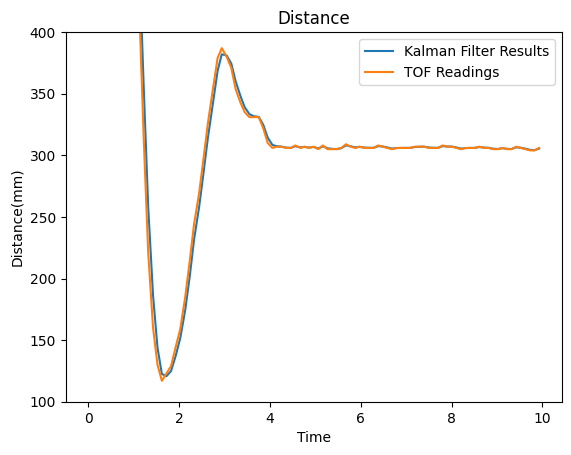

In [80]:
x = np.array([[distanceF[0]],[0]])
sigma = np.array([[20, 0] ,[0, 20]])
#Process noice
s = 25/1000
sigma_1 = s
sigma_2 = s
#Measurement Noise
sigma_3 = 20/1000

Sig_u = np.array([[sigma_1**2,0],[0,sigma_2**2]]) 
Sig_z = np.array([[sigma_3**2]]) 

kfdistance = []
for i in range(len(timeF)):
    x, sigma = kf(x, sigma, 1, distanceF[i])
    kfdistance.append(x[0][0])
kfdistance=np.array(kfdistance)
plt.plot(timeF, kfdistance, label = 'Kalman Filter Results')
plt.plot(timeF, distanceF, label = 'TOF Readings')
plt.title('Distance')
plt.xlabel('Time')
plt.ylim([100,400])
plt.ylabel('Distance(mm)')
plt.legend()
sigma

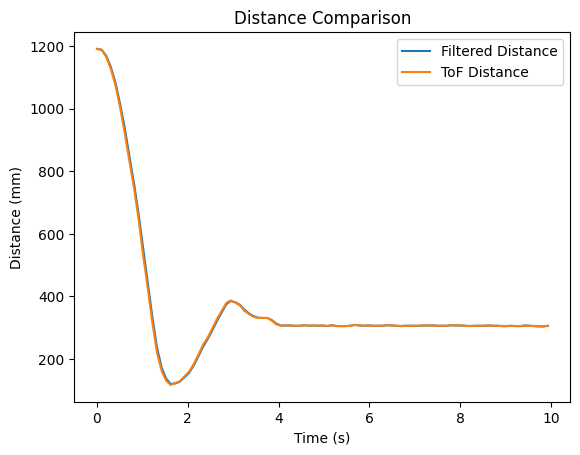

In [67]:
kalman_freq = 20  #20 Hz for Kalman filter
dt = 1 / kalman_freq
Ad = np.eye(2) + dt * A  
Bd = dt * B
mu = np.array([[distanceF[0]],[0]])
u=1
kfdistance = []
for i in range(len(timeF)):
    tof_time = timeF[i]
    
    # Run prediction steps before each ToF update
    if i == 0:
        steps = int(tof_time / dt)
    else:
        steps = int((tof_time - timeF[i - 1]) / dt)
        
    for _ in range(steps):
        # Prediction step (without update)
        mu = Ad.dot(mu) + Bd.dot(u)
        sigma = Ad.dot(sigma).dot(Ad.T) + Sig_u
        
        # Append the predicted state (distance)
        kfdistance.append(mu[0][0])
        current_time += dt
        
    # Update step (when a ToF reading is available)
    mu, sigma = kf(mu, sigma, u, distanceF[i])
    kfdistance.append(mu[0][0])
    current_time = tof_time  # Reset to the current ToF reading's timestamp

# Plot the results
plt.plot(timeF, kfdistance, label='Filtered Distance')
plt.plot(timeF, distanceF, label='ToF Distance')
plt.title('Distance Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')
plt.legend()
plt.show()

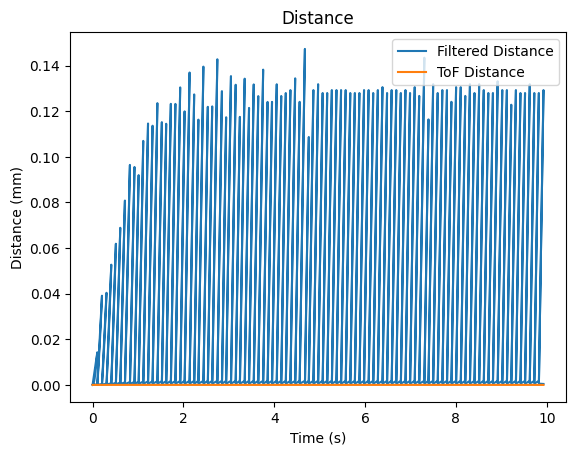

In [117]:
SS_spd = 1560 #estimated steady state speed in mm/s at pwm of 100.
SS_spd90 = 0.9*SS_spd 
t_rising = (t[21]-t[20])/(spd[21] - spd[20])*(SS_spd90-spd[20])+t[20] - 1 #interpolation
u = 1 # Assuming u = 1 Newton
d = u/SS_spd90*1000 
m = -d*t_rising/np.log(0.1) 
A = np.array([[0,1], [0, -d/m]])
B = np.array([[0], [1/m]])
C = np.array([[1,0]])
x = np.array([[distanceF[0]],[0]])
sigma = np.array([[20, 0] ,[0, 20]])
#Process noice
s = 30/1000
sigma_1 = s
sigma_2 = s
#Measurement Noise
sigma_3 = 20/1000

Sig_u = np.array([[sigma_1**2,0],[0,sigma_2**2]]) 
Sig_z = np.array([[sigma_3**2]]) 

dt = 0.001  # Adjust as needed to set the prediction frequency
Ad = np.eye(2) + dt * A
Bd = dt * B

kfdistance = []
predicted_times = []

for i in range(len(timeF)):
    current_time = timeF[i]
    next_time = timeF[i + 1] if i + 1 < len(timeF) else None

    while next_time is not None and current_time + dt < next_time:
        # Prediction step (without update)
        x = Ad.dot(x) + Bd.dot(u)
        sigma = Ad.dot(sigma).dot(Ad.T) + Sig_u
        current_time += dt

        kfdistance.append(x[0][0])
        predicted_times.append(current_time)
    
    # Update step (when a ToF reading is available)
    x, sigma = kf(x, sigma, u, distanceF[i])
    kfdistance.append(x[0][0])
    predicted_times.append(timeF[i])

# Plot the results
plt.plot(predicted_times, kfdistance, label='Filtered Distance')
plt.plot(timeF, distanceF, label='ToF Distance')
plt.title('Distance')
plt.xlabel('Time (s)')
plt.ylabel('Distance (mm)')
plt.legend()
plt.show()

In [92]:
(Ad.dot(x) + Bd.dot(u))

9972

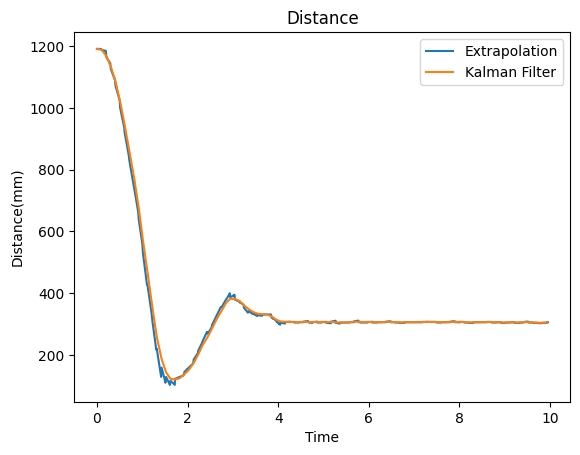

In [58]:
plt.plot(time, distance+304, label = 'Extrapolation')
plt.plot(timeF, kfdistance, label = 'Kalman Filter')
plt.title('Distance')
plt.xlabel('Time')
plt.ylabel('Distance(mm)')
plt.legend();

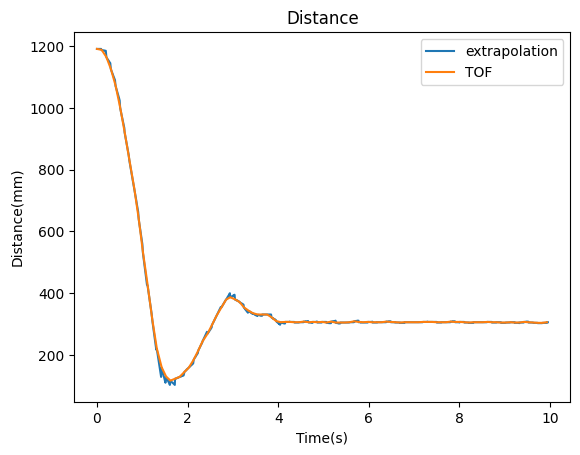

In [23]:
plt.plot(time, distance+304, label = 'extrapolation')
plt.plot(timeF, distanceF, label = 'TOF')
plt.title('Distance')
plt.xlabel('Time(s)')
plt.ylabel('Distance(mm)')
plt.legend();

In [60]:
# Disconnect
ble.disconnect()

2024-04-29 01:57:42,305 | INFO     |: Disconnected from C0:89:C1:6D:24:4B
